In [1]:
import numpy as np
import os
from skimage.measure import block_reduce
from scipy.misc import imread
import cPickle as pkl
import scipy.signal
import numpy.fft as fft
import sys
import optparse
from libtiff import TIFF
from PIL import Image
import re
import itertools
from scipy import ndimage

import math
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.cm as cm
import pandas as pd

%matplotlib inline


In [33]:

threshold = 0.5 #float(options.threshold)

# rev = False #options.rev # CW IS REVERSE

# print "REV STATE: ", rev
get_absolute = True #False #options.get_absolute

key = 'stimulus' #options.key
im_format = '.tif' # '.'+options.im_format
headless = False #options.headless
reduce_factor = (1, 1) #(int(options.reduce_val), int(options.reduce_val))
if reduce_factor[0] > 0:
	reduceit=1
else:
	reduceit=0
gsigma = 0 #int(options.gauss_kernel)
if headless:
	mpl.use('Agg')
	

REV STATE:  True


In [78]:
# outdir = '/media/juliana/TOSHIBA EXT/widefield/CE004/20160203/awake_circle_0013_REV/structs'
outdir = '/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/structs'
# outdir = '/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013/structs'

CW = True #options.rev # CW IS REVERSE

print "REV STATE: ", CW

if rev=='False' and '_CW' in outdir:
    print "Fixing REV status [CW detected in fn]..."
    CW = True

rundir = os.path.split(outdir)[0]
sessiondir = os.path.split(rundir)[0]

print "REV STATE: ", CW


REV STATE:  True
REV STATE:  True


/media/nas/volume1/widefield/data/CE004/20160203
['surface_20160203.tif']
.tif


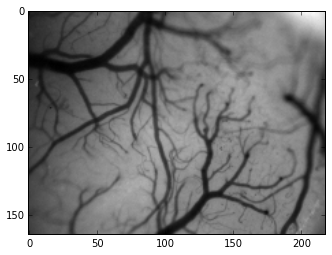

In [80]:
#################################################################################
# GET BLOOD VESSEL IMAGE:
#################################################################################
folders = os.listdir(rundir)
figpath = [f for f in folders if f == 'figures']
print sessiondir

if figpath:
    figdir = figpath[0]
    tmp_ims = os.listdir(os.path.join(sessiondir, figdir))
    surface_words = ['surface', 'GREEN', 'green', 'Surface']
    ims = [i for i in tmp_ims if any([word in i for word in surface_words])]
    print ims
    impath = os.path.join(sessiondir, figdir, ims[0])
    # image = Image.open(impath) #.convert('L')
    # imarray = np.asarray(image)
    print os.path.splitext(impath)[1]
    if os.path.splitext(impath)[1] == '.tif':
        tiff = TIFF.open(impath, mode='r')
        surface = tiff.read_image().astype('float')
        tiff.close()
        plt.imshow(surface)
    else:
        image = Image.open(impath) #.convert('L')
        surface = np.asarray(image)


else: # NO BLOOD VESSEL IMAGE...
    surface = np.zeros([200,300])

if reduceit:
    surface = block_reduce(surface, reduce_factor, func=np.mean)

plt.imshow(surface, cmap='gray')

In [81]:

#################################################################################
# GET DATA STRUCT FILES:
#################################################################################
append = 'nas'

files = os.listdir(outdir)
files = [f for f in files if os.path.splitext(f)[1] == '.pkl']
dstructs = [f for f in files if 'Target_fft' in f and str(reduce_factor) and key in f and append in f]

print dstructs

D = dict()
for f in dstructs:
	outfile = os.path.join(outdir, f)
	with open(outfile,'rb') as fp:
		D[f] = pkl.load(fp)
print D.keys()

cw_key = D.keys()[0]

['Target_fft_stimulus_(1, 1)_nas.pkl']
['Target_fft_stimulus_(1, 1)_nas.pkl']


In [73]:
curr_key = cw_key

(0.0, 6.2831853071795862, -1.0, 1.0)

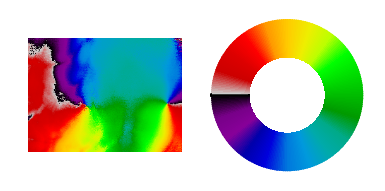

In [74]:
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(np.angle(D[cw_key]['ft']), cmap='spectral')
plt.axis('off')

ax = fig.add_subplot(1,2,2, projection='polar')
ax.set_theta_zero_location('W') # W puts 0 on RIGHT side...

if CW:
    ax._direction = 2*np.pi # object moves toward bottom first (CW)
else:
    ax._direction = -2*np.pi # objecct moves toward top first (CCW)

norm = mpl.colors.Normalize(vmax=1*np.pi, vmin=-1*np.pi)
#norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('spectral'),
                                norm=norm, orientation='horizontal')
# cb.ax.invert_xaxis()
# cb.outline.set_visible(False)
# ax.set_axis_off()
ax.set_rlim([-1, 1])
ax.axis('off')

(164, 218)
/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/structs/CW_phase_overlay_withkey.jpg


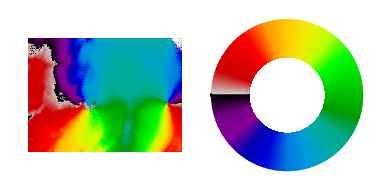

In [75]:
use_mean_intensity = 0 # set to 1 if want to threshold with mean intensity values instead of magnitude
use_log = 1
threshold = 0.7

mag_map = D[curr_key]['mag_map']
phase_map = D[curr_key]['phase_map']

#-----------------------------------------------------------------
# Overlaid Phase-map, thresholded
#-----------------------------------------------------------------

fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(surface,cmap=cm.Greys_r)
print surface.shape

if use_mean_intensity:
    mean_intensity = D[curr_key]['mean_intensity']
    [x, y] = np.where(mean_intensity >= threshold*mean_intensity.max())
    phase_mask = np.ones(mean_intensity.shape) * 100
    # phase_mask[x, y] = phase_map[x, y]
    phase_mask[x, y] = D[curr_key]['phase_map'][x, y]
    tit = 'Threshold, %.2f of mean intensity max' % (threshold)

else:
    if use_log:
        [x, y] = np.where(np.log(mag_map) >= threshold * np.log(mag_map.max()))
    else:
        [x, y] = np.where(mag_map >= threshold * mag_map.max())
    phase_mask = np.ones(mag_map.shape) * 100
    phase_mask[x, y] = phase_map[x, y]
    tit = 'Threshold, %.2f of log max magnitude' % (threshold)

[nullx, nully] = np.where(phase_mask == 100)
phase_mask[nullx, nully] = np.nan
phase_mask = np.ma.array(phase_mask)
plt.imshow(phase_mask, cmap='spectral', vmin=-1*math.pi, vmax=math.pi)
plt.axis('off')


#-----------------------------------------------------------------
# LEGEND
#-----------------------------------------------------------------

ax = fig.add_subplot(1,2,2, projection='polar')
ax.set_theta_zero_location('W') # W puts 0 on RIGHT side...

if CW:
    ax._direction = 2*np.pi # object moves toward bottom first (CW)
else:
    ax._direction = -2*np.pi # objecct moves toward top first (CCW)

norm = mpl.colors.Normalize(vmax=1*np.pi, vmin=-1*np.pi)
#norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('spectral'),
                                norm=norm, orientation='horizontal')
# cb.ax.invert_xaxis()
# cb.outline.set_visible(False)
# ax.set_axis_off()
ax.set_rlim([-1, 1])
ax.axis('off')

if CW:
    imname = 'CW_phase_overlay_withkey'
else:
    imname = 'CCW_phase_overlay_withkey'
impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')


print impath